<a href="https://colab.research.google.com/github/anadiedrichs/2023-nlp-tps/blob/main/2b_bot_dnn_spacy_esp_genero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pipeline NLP transformers
#!pip install -U spacy==3.1 --quiet
#!pip install -U spacy-stanza==1.0.0 --quiet

!pip install -U spacy --quiet
!pip install -U spacy-stanza --quiet



In [ ]:
import json
import string
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish) ...
INFO:stanza:File exists: /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [ ]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [ ]:
# Ejemplo de como funciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

Se propone crear un bot para responder las consultas más comunes referentes al espacio de Género y Diversidad de la UTN FRM, cuya página web es https://www4.frm.utn.edu.ar/genero-y-diversidad/



In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola", "Buenos días"],
             },
             {"tag": "inicio-temporal",
              "patterns": ["¿Cuándo surge la Comisión Asesora de Género y Diversidad?", "¿Desde cuándo está la Comisión?", "¿Hace cuánto está la Comisión Asesora de Género" ],
              "responses": ["La Universidad Tecnológica Nacional Facultad Regional Mendoza crea la Comisión Asesora del Programa de Género Local mediante la resolución 699/2019 CD UTN FRM en el año 2019, en concordancia con la Ley Nº 27.229 “Ley Micaela de Capacitación Obligatoria en Género para Todas las Personas que Integran los Tres Poderes del Estado” y la Ordenanza del Consejo Superior UTN nº 1638 titulada «Protocolo de Acción Institucional para la Prevención e Intervención ante situaciones de Violencia de Género u Orientación Sexual»."]
             },
            {"tag": "funciones",
              "patterns": ["¿Cuáles son las funciones de la Comisión Asesora de Género y Diversidad?", "¿Qué tareas realiza la Comisión?"],
              "responses": ["Las principales funciones de la Comisión son: 1) Recibir consultas o denuncias de aquellas situaciones contempladas por el protocolo y realizar las entrevistas personales a las personas afectadas. 2) Llevar registro de los casos y de las intervenciones institucionales velando por la confidencialidad de los datos que en ellos se consignan, elaborar informes institucionales, brindar asesoramiento y solicitar intervenciones de las áreas que correspondan. 3) Elaborar los expedientes y brindar asesoramiento a tribunales académicos u órganos sumariantes en los casos en los que los hechos por los que se solicita la sanción estén alcanzados por este protocolo. 4)Proponer y llevar adelante acciones tendientes a dar pleno cumplimiento del protocolo, entre ellas, capacitaciones y programas de prevención. "]
             },
            {"tag": "protocolo",
              "patterns": ["¿Qué es un protocolo?", "¿Me explicas qué es el protocolo?"],
              "responses": ["Es un instrumento que contempla una serie de medidas para intervenir ante situaciones de violencia y discriminación basadas en el género u orientación sexual, tendientes a brindar asistencia, protección y resguardo de las personas afectadas, en el ámbito de nuestra universidad. El protocolo garantiza el enfoque de género en el abordaje institucional de las situaciones de violencia y discriminación por género entre los/as integrantes de su comunidad. También garantiza el acompañamiento y orientación de la/s persona/s afectada/s, para evitar la revictimización, la subestimación, la sobreexposición y todo sesgo sexista en el tratamiento de los casos. Además visibiliza la problemática, le da un tratamiento específico y compromete a la Universidad a desarrollar acciones de difusión, capacitación y prevención."]
             },
            {"tag": "protocolo-situaciones",
              "patterns": ["¿Qué situaciones contempla el protocolo?", "¿Qué tipo de violencia contempla el protocolo?","¿Cuáles casos de violencia considera el protocolo?"],
              "responses": ["Comprende situaciones de violencia física, psicológica, sexual, económica y/o simbólica y de discriminación basadas en el sexo y/o género de la persona, orientación sexual, identidad de género y/o expresión de género. Hechos con connotación sexista: toda conducta, o comentario, cuyo contenido discrimine, excluya, subordine, subvalore o estereotipe a las personas debido a su género, identidad de género, orientación sexual que provoque daño, sufrimiento, miedo, afecte la vida, la libertad, la dignidad, integridad psicológica o la seguridad personal. El Protocolo protege, en el mismo sentido que las leyes 23.592 (Contra Actos Discriminatorios), 26.485 (de Protección Integral a las Mujeres) y 26.743 (de Identidad de Género) y los distintos instrumentos internacionales invocados en sus textos, a toda la comunidad universitaria: docentes, no docentes y estudiantes, de pregrado, grado, posgrado, personas que presten servicios en los ámbitos de la UTN; investigadoras/es, becarias/os, o egresadas/os "]
             },
            {"tag": "protocolo-quienes",
              "patterns": ["¿A quiénes está dirigido el protocolo?", "¿A quiénes contempla el protocolo?"],
              "responses": ["El protocolo está dirigido a toda la comunidad universitaria: estudiantes, docentes, no docentes, trabajadores asimilados/as, directivos, secretarios/as, autoridades y/o toda persona, organización o empresa que desarrolle alguna actividad -de manera directa o indirecta- en la universidad."]
             },
            {"tag": "protocolo-acciones",
              "patterns": ["¿Qué acciones pueden tomarse?", "¿Cuáles medidas se aplican a agresores?"],
              "responses": ["Medidas preventivas, de protección y/o sancionatorias en el marco universitario."]
             },
            {"tag": "denuncia",
              "patterns": [ "¿Cómo puedo denunciar?", "Quiero realizar una consulta confidencial"],
              "responses": ["Contactanos: 1) A través del correo electrónico:  generoutnmendoza@gmail.com, 2) A través del formulario online que se encuentra. Las denuncias pueden ser efectuadas por cualquier persona a la que asisten los derechos vulnerados según las situaciones comprendidas, ya sea directamente o por haber conocido o presenciado alguna de las situaciones descriptas. Durante la recepción de las denuncias, se garantiza: respeto y confidencialidad, gratuidad en todo el proceso administrativo, contención, la no revictimización, diligencia y celeridad en el proceso."]
             },

             {"tag": "redes-sociales",
              "patterns": [ "facebook", "instagram", "Tienen redes sociales?"],
              "responses": ["Estamos en Facebook en https://www.facebook.com/people/Consejer%C3%ADa-de-g%C3%A9nero-UTN-FRM/100063749043249/ y también en INSTAGRAM en https://www.instagram.com/consejeriadegeneroutnfrm/"]
             },

             {"tag": "contacto",
              "patterns": [ "¿Cuáles son los canales de contacto?", "Quiero escribirles", "Necesito contactarles"],
              "responses": ["Email institucional generoydiversidad@frm.utn.edu.ar, Denuncias: generoutnmendoza@gmail.com, Whatsapp: +54 9 2616 15-4327. También estamos en Facebook en https://www.facebook.com/people/Consejer%C3%ADa-de-g%C3%A9nero-UTN-FRM/100063749043249/ y también en INSTAGRAM en https://www.instagram.com/consejeriadegeneroutnfrm/"]
             },
             {"tag": "referente",
              "patterns": [ "¿Quién es la persona referente?", "¿Con quién puedo hablar?"],
              "responses": ["La persona referente de la Comisión Asesora de Género y Diversidad es la Lic. Georgina Sanchez"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hasta pronto!"]
             }
]}



### 4 - Preprocesamiento y armado del dataset

In [ ]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'acción', 'agresor', 'aplicar', 'asesora', 'canal', 'caso', 'chau', 'comision', 'como', 'con', 'confidencial', 'considerar', 'consulta', 'contactar', 'contacto', 'contemplar', 'cual', 'cuando', 'cuanto', 'de', 'denunciar', 'desde', 'dirigido', 'diversidad', 'el', 'escribir', 'este', 'explicar', 'facebook', 'función', 'genero', 'hablar', 'hacer', 'hasta', 'hola', 'instagram', 'luego', 'medida', 'necesitar', 'persona', 'poder', 'protocolo', 'que', 'querer', 'quien', 'realizar', 'red', 'referente', 'ser', 'situación', 'social', 'surgir', 'tal', 'tarea', 'tener', 'tipo', 'tomar', 'uno', 'violencia', 'y', 'yo', 'él']
classes: ['bienvenida', 'contacto', 'denuncia', 'despedida', 'funciones', 'inicio-temporal', 'protocolo', 'protocolo-acciones', 'protocolo-quienes', 'protocolo-situaciones', 'redes-sociales', 'referente']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cuándo surge la Comisión Asesora de Género y Diversidad?', '¿Desde cuándo está la Comisión?', '¿Hace cuánto está la

In [ ]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 63


In [ ]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 12


In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

### 5 - Entrenamiento del modelo

In [ ]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (63,) output: 12


In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8192      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                780       
                                                                 
Total params: 17,228
Trainable params: 17,228
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 723ms/step - loss: 2.5439 - accuracy: 0.1379
Epoch 2/200
1/1 [==============================] - 0s 9ms/step - loss: 2.5045 - accuracy: 0.0690
Epoch 3/200
1/1 [==============================] - 0s 6ms/step - loss: 2.5295 - accuracy: 0.1379
Epoch 4/200
1/1 [==============================] - 0s 7ms/step - loss: 2.4426 - accuracy: 0.0690
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 2.4984 - accuracy: 0.1379
Epoch 6/200
1/1 [==============================] - 0s 10ms/step - loss: 2.4624 - accuracy: 0.2414
Epoch 7/200
1/1 [==============================] - 0s 9ms/step - loss: 2.5367 - accuracy: 0.0690
Epoch 8/200
1/1 [==============================] - 0s 8ms/step - loss: 2.4768 - accuracy: 0.1724
Epoch 9/200
1/1 [==============================] - 0s 7ms/step - loss: 2.4039 - accuracy: 0.1379
Epoch 10/200
1/1 [==============================] - 0s 7ms/step - loss: 2.3553 - accuracy: 0.1724
Epoch 11/200
1/1 [========

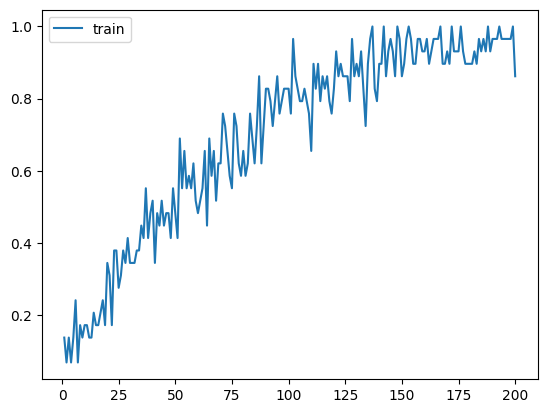

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [ ]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [ ]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents:
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria
            result = random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")


hola
Q: hola
1/1 [==============================] - 0s 95ms/step
BOT: Hola
Cómo hago una denuncia?
Q: Cómo hago una denuncia?
1/1 [==============================] - 0s 15ms/step
BOT: Contactanos: 1) A través del correo electrónico:  generoutnmendoza@gmail.com, 2) A través del formulario online que se encuentra. Las denuncias pueden ser efectuadas por cualquier persona a la que asisten los derechos vulnerados según las situaciones comprendidas, ya sea directamente o por haber conocido o presenciado alguna de las situaciones descriptas. Durante la recepción de las denuncias, se garantiza: respeto y confidencialidad, gratuidad en todo el proceso administrativo, contención, la no revictimización, diligencia y celeridad en el proceso.
garantizan confidencialidad?
Q: garantizan confidencialidad?
BOT: Perdón, no comprendo la pregunta.
Que hace la comision'
Q: Que hace la comision'
1/1 [==============================] - 0s 14ms/step
BOT: Las principales funciones de la Comisión son: 1) Recibir

KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.